In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [4]:
#Lee imagen de archivo
img = cv2.imread('mandril.jpg')
#Conversión de la imagen a niveles de grises de la imagen original en BGR
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Obtiene contornos con el operador de Canny
#Parámetros: imagen de entrada, umbral inferior, umbral superior
canny = cv2.Canny(gris, 100, 200)

TAREA I: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

7 filas llegan como mínimo al 90% del máximo (0.4296875) [(6, np.float64(0.396484375)), (12, np.float64(0.4296875)), (15, np.float64(0.3984375)), (20, np.float64(0.390625)), (21, np.float64(0.392578125)), (88, np.float64(0.388671875)), (100, np.float64(0.4140625))]


(0.0, 512.0)

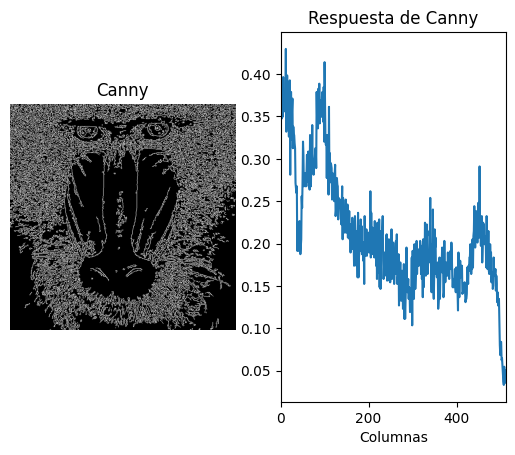

In [6]:
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows = row_counts[:, 0] / (255 * canny.shape[1])

max_row = max(rows)
threshold = 0.9 * max_row
max_values = [(i, v) for i, v in enumerate(rows) if v >= threshold]
print(f"{len(max_values)} filas llegan como mínimo al 90% del máximo ({max_row})", max_values)

#Muestra dicha cuenta gráficamente
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(rows)
#Rango en x definido por las columnas
plt.xlim([0, canny.shape[0]])

TAREA II: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

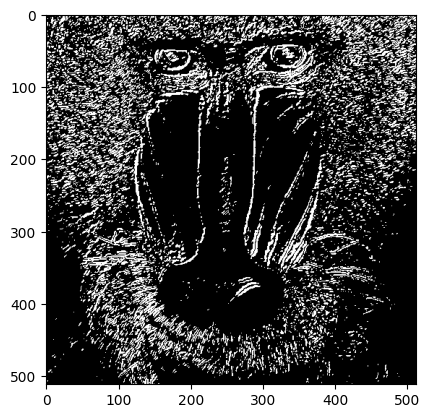

4 columnas llegan como mínimo al 90% del máximo (55845) [(104, 54060), (105, 52275), (127, 55845), (288, 54315)]
19 filas llegan como mínimo al 90% del máximo (55080) [(2, 51765), (3, 53550), (4, 54315), (5, 50490), (8, 54570), (11, 51510), (12, 52020), (19, 49980), (20, 51000), (24, 53550), (51, 51255), (80, 51510), (81, 51000), (82, 53295), (83, 55080), (84, 50745), (85, 51255), (87, 51765), (100, 53040)]


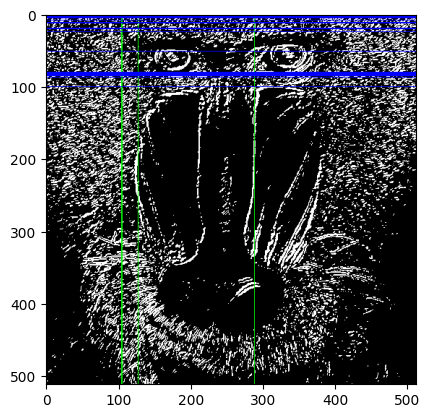

In [ ]:
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
ggris = cv2.GaussianBlur(gris, (3, 3), 0)

#Calcula en ambas direcciones (horizontal y vertical)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y
#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)

# Conversión a byte con openCV
sobel8 = cv2.convertScaleAbs(sobel)
#Define valor umbral
valorUmbral = 100 #Prueba otros valores
#Obtiene imagen umbralizada para dicho valor definido
_, sobelUmbralizado = cv2.threshold(sobel8, valorUmbral, 255, cv2.THRESH_BINARY)
#Muestra resultado
plt.imshow(sobelUmbralizado, cmap='gray')
plt.show()

num_cols = len(sobelUmbralizado[0])
cols_count_umbralizado = [0] * num_cols
for col in range(num_cols):
    for row in range(len(sobelUmbralizado)):
        cols_count_umbralizado[col] += int(sobelUmbralizado[row][col])

max_col = max(cols_count_umbralizado)
threshold = 0.9 * max_col
max_col_values = [(i, v) for i, v in enumerate(cols_count_umbralizado) if v >= threshold]
print(f"{len(max_col_values)} columnas llegan como mínimo al 90% del máximo ({max_col})", max_col_values)

# Convertir a BGR para pintar en color
output = cv2.cvtColor(sobelUmbralizado, cv2.COLOR_GRAY2BGR)

# Dibujar líneas verdes para las columnas
for (col_idx, val) in max_col_values:
    cv2.line(output, (col_idx, 0), (col_idx, output.shape[0]-1), (0,255,0), 1)

# Se encuentran las filas que sean al menos un 90% del máximo
num_rows = len(sobelUmbralizado)
row_vals = [0] * num_rows
for i, x in enumerate(sobelUmbralizado):
    for j, y in enumerate(x):
        row_vals[i] += int(sobelUmbralizado[i][j])
row_threshold = 0.9 * max(row_vals)
max_row_values = [(i, v) for i, v in enumerate(row_vals) if v >= row_threshold]
print(f"{len(max_row_values)} filas llegan como mínimo al 90% del máximo ({max(row_vals)})", max_row_values)


for (row_idx, val) in max_row_values:
    cv2.line(output, (0, row_idx), (output.shape[1]-1, row_idx), (255,0,0), 1)

# Mostrar en colores correctos
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

TAREA III: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.

In [ ]:
import cv2
import numpy as np

# Parámetros para el modo 4
ncells = 10   # Tamaño de celda
off = ncells // 2

# Variable global de modo
modo = 0

def cambiar_modo(event, x, y, flags, param):
    global modo
    if event == cv2.EVENT_LBUTTONDOWN:
        modo = (modo + 1) % 5    # ahora hay 5 modos (0–4)
    elif event == cv2.EVENT_RBUTTONDOWN:
        modo = 0

# Abrir cámara
vid = cv2.VideoCapture(0)

# Asociar callback de ratón a la ventana
cv2.namedWindow("TAREA 3")
cv2.setMouseCallback("TAREA 3", cambiar_modo)

disponible = 0
pframe = None

while True:
    ret, frame = vid.read()
    if not ret:
        break

    if modo == 0:
        output = frame.copy()
        texto = "Mode: Normal"

    elif modo == 1:
        if disponible > 0 and pframe is not None:
            output = cv2.absdiff(frame, pframe)
        else:
            output = frame.copy()
            disponible = 1
        pframe = frame.copy()
        texto = "Mode: Difference"

    elif modo == 2:
        output = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        texto = "Mode: Gray"

    elif modo == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray)

        output = frame.copy()
        cv2.circle(output, minLoc, 10, (255, 0, 0), 2)   # más oscuro = azul
        cv2.circle(output, maxLoc, 10, (0, 255, 255), 2) # más claro = amarillo
        texto = "Mode: Brightest and darkest pixel"

    elif modo == 4:
        # Dimensiones originales
        h, w, c = frame.shape
        # Reducción
        down_frame = cv2.resize(frame, (w // ncells, h // ncells), cv2.INTER_NEAREST)
        h2, w2, _ = down_frame.shape

        # Separamos canales
        b = down_frame[:, :, 0]
        g = down_frame[:, :, 1]
        r = down_frame[:, :, 2]

        # Imagen de salida (colorida)
        color_up_frame = np.zeros((h2 * ncells, w2 * ncells, 3), dtype=np.uint8)

        for y in range(h2):
            for x in range(w2):
                rad = int((r[y, x] + g[y, x] + b[y, x]) / (ncells * 3 * 2))
                
                # Colores estilo pop art según intensidad
                if rad < 3:
                    color = (255, 0, 0)   # azul
                elif rad < 6:
                    color = (0, 0, 255)   # rojo
                else:
                    color = (0, 255, 0)   # verde

                cv2.circle(color_up_frame, (x * ncells + off, y * ncells + off), rad, color, -1)

        output = color_up_frame
        texto = "Mode: Circle collection"

    # Convertir a BGR si es gris
    if len(output.shape) == 2:
        output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

    # Texto sobre la imagen
    cv2.putText(output, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(output, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            1, (50, 255, 0), 2, cv2.LINE_AA)
    
    # Mostrar resultado
    cv2.imshow("TAREA 3", output)

    # Salir con ESC
    if cv2.waitKey(20) == 27:
        break

# Liberar recursos
vid.release()
cv2.destroyAllWindows()

C:\Users\User\AppData\Local\Temp\ipykernel_20260\374306567.py:76: RuntimeWarning: overflow encountered in scalar add
  rad = int((r[y, x] + g[y, x] + b[y, x]) / (ncells * 3 * 2))


TAREA IV: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [12]:
import mediapipe as mp

# For controlling system volume (Windows only)
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

# Setup Pycaw (system audio controller)
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))

vol_range = volume.GetVolumeRange()  # (min, max) in dB
min_vol, max_vol = vol_range[0], vol_range[1]

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)  # Flip for mirror view
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get coordinates of thumb tip (id=4) and index tip (id=8)
            h, w, _ = frame.shape
            x1, y1 = int(hand_landmarks.landmark[4].x * w), int(hand_landmarks.landmark[4].y * h)
            x2, y2 = int(hand_landmarks.landmark[12].x * w), int(hand_landmarks.landmark[12].y * h)
            
            # Draw landmarks
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.circle(frame, (x1, y1), 8, (255, 0, 0), cv2.FILLED)
            cv2.circle(frame, (x2, y2), 8, (255, 0, 0), cv2.FILLED)
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Distance between thumb and index
            length = np.hypot(x2 - x1, y2 - y1)
            
            # Map length to volume range
            vol = np.interp(length, [20, 200], [min_vol, max_vol])
            volume.SetMasterVolumeLevel(vol, None)
            
            # Visual feedback: volume bar
            vol_bar = np.interp(length, [20, 200], [400, 150])
            cv2.rectangle(frame, (50, 150), (85, 400), (0, 255, 0), 2)
            cv2.rectangle(frame, (50, int(vol_bar)), (85, 400), (0, 255, 0), cv2.FILLED)

    cv2.imshow("Hand Volume Control", frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27:  # 'q' or ESC
        break

cap.release()
cv2.destroyAllWindows()
